# A text analysis for comments of video channels

In [1]:
from IPython.core.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

**Note:**
* If you want to change the notebook mode to view the source code, please click the above link.
* All the graphs/charts(except the word cloud) are interactive, you can click the charts to view more details. 

## Executive Summary 

This notebook is about the text analysis of data "csrp data science challenge.xlsx".  The aim is to get insights from the data so that recommendations and suggestions can be provide to the channels and their video content, Its also the chance to let content providers know about their viewers' portrait. All analysis is done by Python programming, and the methods including Time series, descriptive statistics analysis, text analysis, topic modeling and sentiment modeling. Note that bias is not into consideration due to the data has been already given. 

The following are some most important insights and recommendations.

1.  People are enjoying watching more and more videos(without comparing with other entertaining ways). Keep update videos, more videos, more likely to get more views.
2. Generally, channels should publish more content related to the topic(Music and show)  to gain more views.
3.  If you want to make the viral video, topic(music and show) is your choice, if you want to be a consistent youtuber or content provider, topic(political related)  shares the similar views with the topic(music and show) on average video.
4.  If you want to get more views, you should generally be a positive content provider. Negative comments on channel level are more likely related to low views.

There are still many things can be improved and further discussed, including Building our own corpus,
Hong Kong traditional Chinese words segmentation library, enrich data, etc. For the next step details, please refer to the last chapters.

## Table of content

## 1. Exploratory analysis for general information
### 1.1. Time seires 
#### 1.1.1. Year trend with video count
#### 1.1.2. Year trend with video views
### 1.2. Prevalence: what are the most viewed channels
### 1.3. Persistence: what are the most active channels
### 1.4. Words frequency and Word cloud
## 2. Topic Modeling - LDA
### 2.1. Video Level
#### 2.1.1. Top 5 models in video level and visualization
#### 2.1.2. Classify every video into 5 topics 
#### 2.1.3. Compare view performance with each topic
### 2.2. Channel Level
#### 2.2.1. Top 5 models in channel level and visualization
#### 2.2.2. Classify every channel into 5 topics
#### 2.2.3. Compare view performance with each topic
### 2.3. Optimize the model - Choosing Optimal LDA Model
### 2.4. Brief summary
## 3. Sentiment Analysis
### 3.1. Sentiment analysis with SnowNLP
#### 3.1.1. Predict comments sentiment in video - level
#### 3.1.2. Predict comments sentiment in channel - level
### 3.2. Sentiment analysis with tensorflow: RNN-Embedding-BiLSTM-LSTM
### 3.3. Compare performance with SnowNLP and LSTM
## 4. Insights and recommendations
## 5. Next step

In [242]:
import re
import nltk
import jieba
import string
import opencc
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pyecharts import Pie
import matplotlib.pyplot as plt
from scipy.misc import imread 
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS

In [3]:
df1 = pd.read_excel('csrp data science challenge.xlsx', index_col=0,sheet_name=0)

Firstly, let's have a look at our dataset. The following are the first 5 rows of the whole dataset after we merged sheet 1 & 2

In [394]:
#df = pd.merge(df1,df2,on=['videoId'],how='left')
df.head()

,commentText,updatedAt,videoId,channelTitle,publishedAt,title,viewCount,video_count
6914,我們要求,2016-06-06 23:19:13,67JzSRnyXr4,Blippi,2016-05-22 16:30:24,Learn The Alphabet With Blippi | ABC Letter Boxes,67869205.0,1.0
683,陳怡蓉以前好清新脫，現在變得好俗、土土的,2016-04-24 13:34:55,RPWDeLqsN0g,杰威爾音樂 JVR Music,2012-09-14 17:49:08,"周杰倫【龍捲風 官方完整MV】Jay Chou ""Tornado"" MV (Long-Jua...",13873838.0,1.0
1084,十多年前，當初所聽到的第一首Jay的歌便是這首,2016-01-23 11:19:52,RPWDeLqsN0g,杰威爾音樂 JVR Music,2012-09-14 17:49:08,"周杰倫【龍捲風 官方完整MV】Jay Chou ""Tornado"" MV (Long-Jua...",13873838.0,1.0
1285,別把大家當白癡 周神偷,2016-04-23 03:22:00,RPWDeLqsN0g,杰威爾音樂 JVR Music,2012-09-14 17:49:08,"周杰倫【龍捲風 官方完整MV】Jay Chou ""Tornado"" MV (Long-Jua...",13873838.0,1.0
1448,被捲到火星還是要聽,2016-04-27 07:14:09,RPWDeLqsN0g,杰威爾音樂 JVR Music,2012-09-14 17:49:08,"周杰倫【龍捲風 官方完整MV】Jay Chou ""Tornado"" MV (Long-Jua...",13873838.0,1.0


You can see that this is a **"Channel-Video-Comments"** 3 layers dataset, understanding it might be helpful for our later analysis.

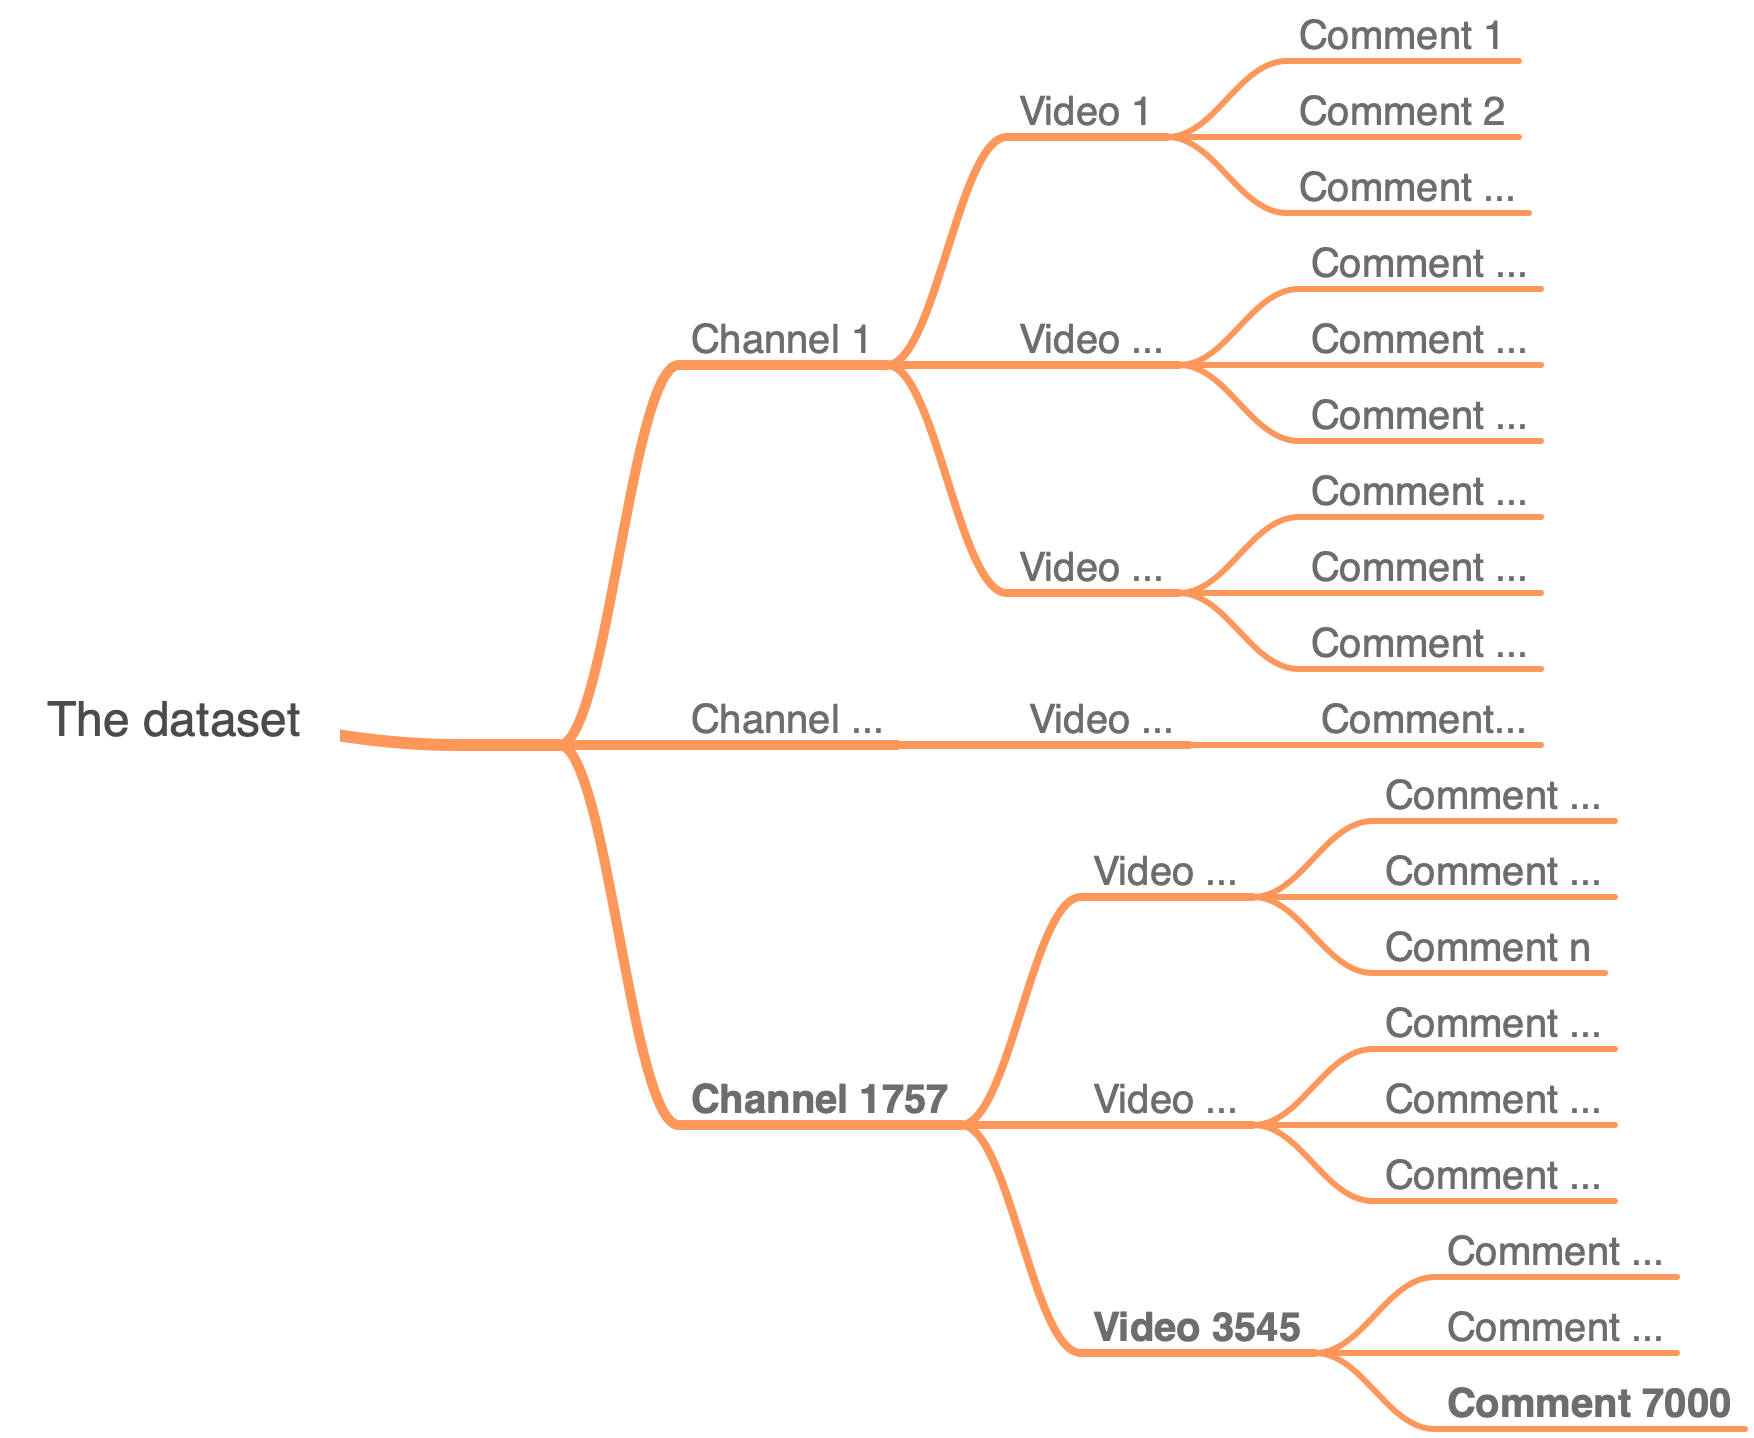

In [35]:
from IPython.display import Image
Image("The dataset.png",width=600, height=600)

In [4]:
df2 = pd.read_excel('csrp data science challenge.xlsx', index_col=0,sheet_name=1)

In [5]:
df1 = df1.reset_index()

In [ ]:
df1.head()

In [ ]:
df1['videoId'].value_counts()

In [8]:
df2 = df2.reset_index()

In [ ]:
df2.head()

## 1. Exploratory analysis for general information

In [ ]:
df2

In [11]:
df2['video_count'] = 1

In [ ]:
df_t1 = df2.set_index('publishedAt').resample('1y').aggregate({'video_count':'sum'}).reset_index()
df_t1

In [13]:
from pyecharts import Line

attr = df_t1['publishedAt']
value = df_t1['video_count']
line = Line()
line.add(
    "Year trend with the video count",
    [str(y)[:10] for y in attr],
    value,
    mark_point=["max", "min"],
    mark_line=["average"],
)
line.render('Year trend with video count.html')

### 1.1. Time series

#### 1.1.1. Year trend with video count

We can see that the videos in each year in the dataset are increasing and most of them are from 2016.

In [390]:
from IPython.display import IFrame
IFrame('output-charts&graphs/Year trend with video count.html',800,400)

In [ ]:
df_t2 = df2.set_index('publishedAt').resample('1y').aggregate({'viewCount':'sum'}).reset_index()
df_t2

#### 1.1.2. Year trend with video views

From this chart, we can see that the whole views are keeping a similar increasing pace with the video numbers, which may be a sign that people are watching more and more videos

In [391]:
attr = df_t2['publishedAt']
value = df_t2['viewCount']
line = Line()
line.add(
    "Year trend with video views",
    [str(y)[:10] for y in attr],
    value,
    mark_point=["max", "min"],
    mark_line=["average"],
)
line.render('Year trend with video views.html')
IFrame('output-charts&graphs/Year trend with video views.html',800,400)

### 1.2. Prevalence: what are the most viewed channels
I filter out the top 20 viewed channels, and found out that most of the channels have less than 5 videos, which means that the most viewed channels are not winning by the quantity but others, like content itself.

In [ ]:
df3 = df2.pivot_table(index=['channelTitle'],values='viewCount',aggfunc='sum').reset_index()
df3 = df3.sort_values(by='viewCount',ascending=False)[:20]
df3

In [402]:
from pyecharts import Bar

attr = df3['channelTitle']
v = df3['viewCount']
bar = Bar("Most viewed channels")
bar.add("Most viewed channels", attr, v,is_label_show=False)
bar.render('output-charts&graphs/most-viewed-channels.html')

In [403]:
IFrame('output-charts&graphs/most-viewed-channels.html',800,420)
#you can click on table or labels

In [ ]:
df4 = df2.sort_values(by='viewCount',ascending=False)[:10]
df4

In [ ]:
df5 = df2.pivot_table(index=['channelTitle'],values='videoId',aggfunc='count').reset_index()
df5 = df5.sort_values(by='videoId',ascending=False)[:20]
df5

In [22]:
dft = df2.pivot_table(index=['channelTitle'],values='videoId',aggfunc='count').reset_index().sort_values(by='videoId',ascending=False)

In [ ]:
dft[dft['channelTitle'] == 'Sk Chung']

### 1.3. Persistence: what are the most active channels
The most active channels are basically all from news or news reviews channel, even though they process a lot of videos, but only three of them make to the list of top viewed channels 

In [24]:
attr = df5['channelTitle']
v = df5['videoId']
pie = Pie()
pie.add("channel layout", attr, v, is_label_show=False,center = [70,60],legend_orient="vertical",legend_pos="left")
pie.render('channel layout.html')

In [393]:
IFrame('output-charts&graphs/channel layout.html',800,420)
#you can click on table or labels

### 1.4. Words frequency and Word cloud

#### Merge two table into one

In [26]:
df = pd.merge(df1,df2,on=['videoId'],how='left')

This is how this dataset like:

In [27]:
df.head()

,commentText,updatedAt,videoId,channelTitle,publishedAt,title,viewCount,video_count
0,一口就吃掉一千元，，这谁吃的起啊,2016-02-17 18:26:21,UvWOfjiXQiU,NeoKing5168,2010-09-26 01:07:19,非凡大探索_美食大學堂_鮑魚教父雙雄,23272.0,1.0
1,我試試,2016-12-22 21:33:05,w_VJAynyxAw,徐聖傑,2010-10-18 18:03:18,菜鳥挑戰毒氣室2,438.0,1.0
2,原來你跟我一樣,2016-02-24 00:55:01,DxforOx--9Q,Pumpkin Jenn,2015-04-12 20:35:23,🎃 包包大解拆 What's in My Bag | Pumpkin Jenn🎃,182411.0,1.0
3,链接链接吧的人员来,2016-02-06 10:25:05,-foZ5RcCm8U,China History,2015-02-02 00:56:04,中国历史地图 Historical Atlas of China,995311.0,1.0
4,这个力度，沉凝内敛，是真功夫,2016-12-18 15:29:14,_IbK0X3Qi3I,zxmsf,2009-03-18 19:39:57,书坛耆宿-胡铁生,1634.0,1.0


In [ ]:
df=df.sort_values(['viewCount','publishedAt'],ascending=[False,False])
df

#### Analyzing Process
* Words segmentation with jieba
* Remove stopwords and modify stopwords
* Change all the simple chinese to hk-traditional
* Replace synonym, like 中共、共匪、共产党 to 共产党
* Add local words into jieba library, like 蔡英文、习近平、一带一路...

In [29]:
#convert words to hong kong traditional 
cc = opencc.OpenCC('s2hk')
def to_hk(text):
    return cc.convert(text)
text = df['commentText'].apply(to_hk).to_string()

def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords 
stopwords = stopwordslist('Chinese_Stopwords.txt')
#i add several words we discussed into stopwords
#you can find them in top of the Chinese_Stopwords.txt

In [ ]:
#build local words
jieba.add_word('習近平')
jieba.add_word('一首歌')
jieba.add_word('中華民國')
jieba.add_word('習主席')
jieba.add_word('一帶一路')
jieba.add_word('洗腦')
jieba.add_word('蔡英文')
#cut text
def text_cut(text):  
    return [w for w in jieba.cut(text) if w not in stopwords and len(w)>1] 

#if you got error "ImageColorGenerator is smaller than the canvas"
#please go back to last cell to adjust max_font_size= ??? & max_words=???
#usually reduce the value will work

textcut = text_cut(text)
mapping={
    '中共':'共產黨',
    '濤哥':'石濤',
    '共匪':'共產黨'
}
def cleaning(e):
    return mapping.get(e,e)

text_clean = []
for t in textcut:
    t = cleaning(t)
    text_clean.append(t)

In [31]:
from plotly.offline import iplot, plot
import plotly.graph_objs as go
import plotly
def word_count_top_20(textcut):
    word_count = pd.Series(textcut).value_counts().sort_values(ascending=False)[0:20]
    plotly.offline.init_notebook_mode(connected=True)

    data = [go.Bar(
                x=word_count.index.tolist(),
                y=word_count.values.tolist(),
                marker=dict(
            color='rgba(185,20,10,0.8)'
        ) 
        )]
    layout = go.Layout(
        title='Top words',
    )

    fig = go.Figure(data=data, layout=layout)
    plot(fig, filename='Top words')
    return 

In [366]:
#generate word_tag
def word_tag(textcut):
    image = Image.open(r'newspaper.png')
    graph = np.array(image)
    wc = WordCloud(font_path=r"simhei.ttf",mode='RGBA',background_color=None,max_font_size=200,mask=graph,collocations=False,max_words=200)
    wc.generate(' '.join(textcut))
    img = imread('color.png')  
    cloud_colors = wordcloud.ImageColorGenerator(np.array(img))  
    wc.recolor(color_func=cloud_colors) 
    wc.to_file(r"output-charts&graphs/word cloud.png") 
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word cloud', loc='Center', fontsize=20)
    plt.show()
    return plt.show()

After the processing mentioned above, the following are the words with top frequency. We can see that most of them are political related and others are people's attitude about the shows and music. 

In [367]:
word_count_top_20(text_clean)
IFrame('output-charts&graphs/Top words.html',800,400)

In [ ]:
word_tag(text_clean)

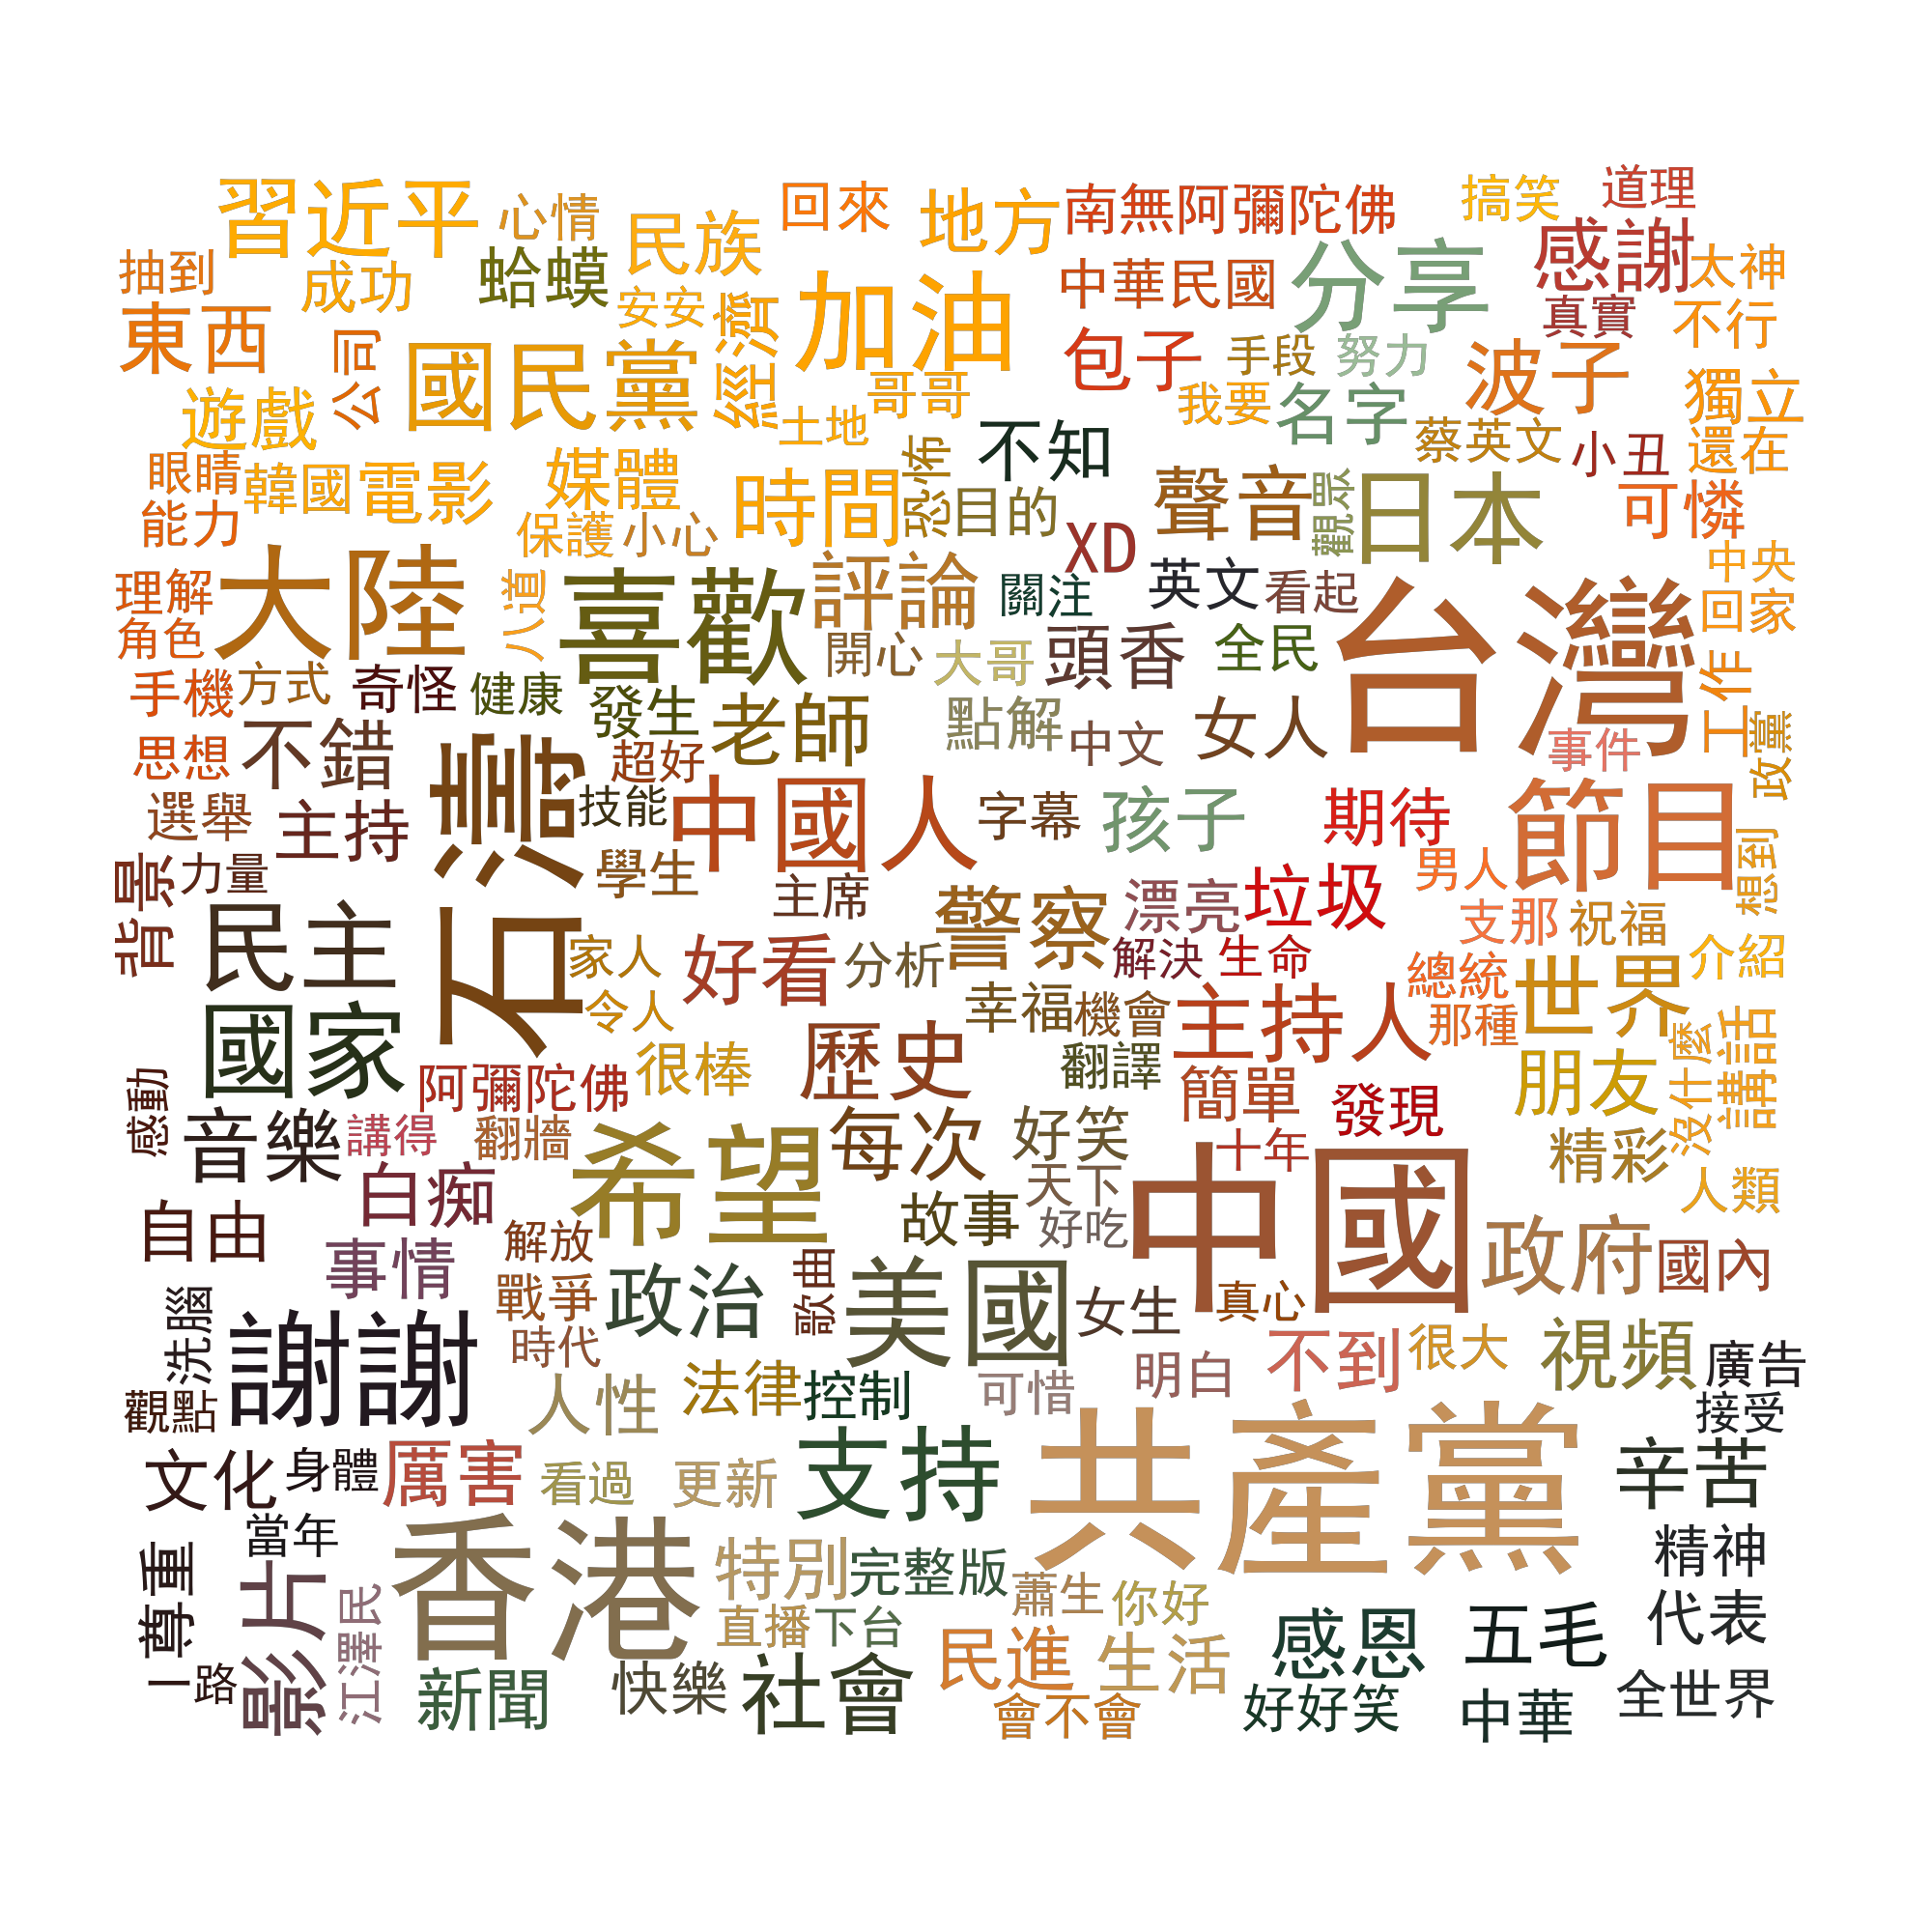

In [389]:
from IPython.display import Image
Image("output-charts&graphs/word cloud.png",width=600, height=600)

## 2. Topic Modeling - LDA
From above-merged dataset, we can know that the structure of the dataset contains **"Channel - Video - Comment"** 3 layers, and there are 1757 channels, 3545 videos and 7000 comments. Therefore, we might need to choose which level to do topic modeling. Considering that some comments are only one or two words, the results will not be good if using **Comment** level. I Decide to use Video level and Channel level, and do a comparision with those two methods.

In [162]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
df.head()

In [ ]:
df['videoId'].value_counts()

### 2.1. Video level

In [ ]:
df_v = df.groupby('videoId').aggregate({'commentText':'sum', 'viewCount':'sum'}).reset_index()
df_v

In [187]:
#cut word
def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))

#set up stopwords
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords 
stopwords = stopwordslist('Chinese_Stopwords.txt')

In [188]:
df_v["content_cutted"] = df_v.commentText.apply(to_hk)
df_v["content_cutted"] = df_v.content_cutted.apply(chinese_word_cut)
df_v["content_cutted"] = df_v["content_cutted"].apply(cleaning)

In [ ]:
df_v["content_cutted"]

In [ ]:
# get stopwords
# get vectorized data and prepare for lda model
n_features = 1000
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words= stopwords,
                                max_df = 0.5,
                                min_df = 10)
data_vectorized = tf_vectorizer.fit_transform(df_v.content_cutted)

In [ ]:
data_vectorized

In [ ]:
#train lda model
n_topics = 5
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                evaluate_every = -1,
                                learning_decay=0.5)
# lda_model.fit(tf)
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model) 

#### 2.1.1. Top 5 topics in video level and visualization

The following are the top 5 topics about the aggregation of the comments on **video level**. We can see that:
* Topic 0 is about taiwan and regional issues
* Topic 1 is about politics and China
* Topic 2 is about Hong Kong and film
* Topic 3 is about Music and show
* Topic 4 is also about the politics, but in a more nagetive way, you can see people are arguing with each other by the words 包子， 五毛

In [193]:
#get words of the topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]                        
    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

#you can change number of n_top_words
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_model, tf_feature_names, n_top_words)

Topic #0:
台灣 日本 聲音 白痴 好看 生命 不到 厲害 名字 記者 公司 英文 男生 發現 主持 上海 講話 好笑 更新 可惜
Topic #1:
中國 民主 台灣 政治 大陸 社會 中共 國家 政府 世界 國民黨 自由 歷史 民族 經濟 中國人 地方 共產黨 力量 文化
Topic #2:
香港 加油 影片 垃圾 主持人 每次 東西 時間 故事 分享 視頻 簡單 方法 回來 人生 支那 努力 韓國 網站 有用
Topic #3:
喜歡 希望 警察 老師 支持 孩子 女人 朋友 不錯 音樂 辛苦 男人 幸福 背景 尊重 開心 節目 哥哥 很棒 真心
Topic #4:
謝謝 中共 濤哥 節目 美國 石濤 共匪 中國人 共產黨 包子 不知 五毛 感恩 評論 分享 電影 人性 蛤蟆 感謝 事情



The following are the visualization of the top 5 topics. topic about politics and China is the most dominant one.
* Note that the topic number is not the same as the above. But you can click each circle to see which topic it is
* The area of circle represents the importance of each topic over the entire corpus, the larger the circle is, the more important this topic is
* The distance between the center of circles indicate the similarity between topics.

In [368]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
ldavis_prepared = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, tf_vectorizer,mds='tsne')
pyLDAvis.save_html(ldavis_prepared,'output-charts&graphs/lda topics - video level.html')

In [378]:
IFrame('output-charts&graphs/lda topics - video level.html',1500,800)

In [195]:
topic=[]
for i in range(len(lda_output)):
    t = dict((k,lda_output[i][k]) for k in range(len(lda_output[i])))
    topic_id = sorted(t.items(),key= lambda x: x[1], reverse=True) # Take the topic with the highest probability as the subject of the text
    if topic_id[0][1] == 0.2:
        topic_id = 'neither,the comments is too short'
    else:
        topic_id = topic_id[0][0]
    topic.append(topic_id)

In [ ]:
lda_output[0]

In [197]:
df_v['topic'] = topic

In [ ]:
df_v

#### 2.1.2. Classify every video into 5 topics

From the following topic distributions in video level, the following are the topic counts in 3545 videos, except the comments that are too short to be classified, we can see that the topics are distributed evenly, and topic 3 (Music and show) is the relatively dominant topic 

In [385]:
print('Topic Distributions in video level:')
df_v['topic'].value_counts()

Topic Distributions in video level:


neither,the comments is too short    1409
3                                     509
1                                     470
4                                     412
0                                     393
2                                     352
Name: topic, dtype: int64

In [200]:
df_v = df_v.sort_values(by='viewCount',ascending = False)

#### 2.1.3. Compare view performance with each topic

After I sort the video-level data by **viewCount** from the highest to lowest, we can found out half of the top 10 most viewed video are the topic 3(Music and show), which may illustrate that people are more likely to watch videos in this topic(**not considering the sample data bias**)

In [201]:
df_v[:11]

,videoId,commentText,viewCount,content_cutted,topic
1552,RPWDeLqsN0g,陳怡蓉以前好清新脫，現在變得好俗、土土的十多年前，當初所聽到的第一首Jay的歌便是這首別把大...,152612218.0,陳 怡蓉 以前 好 清新 脱 ， 現在 變得 好俗 、 土土 的 十多年 前 ， 當初 所 ...,0
39,-foZ5RcCm8U,链接链接吧的人员来不知道以后版图还会怎么变最後音樂好悲慘。看着这个视频特别有感触，想的太多，...,90573301.0,鏈接 鏈接 吧 的 人員來 不 知道 以後版圖 還會 怎麼 變 最後音 樂好 悲慘 。 看着...,1
406,67JzSRnyXr4,我們要求,67869205.0,我們 要求,"neither,the comments is too short"
2916,ooqDc0Ig174,我的左耳好寂寞在當兵時遇兵變，這首歌跟我在台中港聴了二年，想一想也十多年了。好听的歌。真的真...,24013032.0,我 的 左耳 好 寂寞 在 當兵 時遇 兵變 ， 這 首歌 跟 我 在 台中港 聴 了 二年...,0
562,8uhvP8ryU1I,"版主以後能不能把音量調大聲一點, 我已經調到最大聲, 音量還是很小。雖然這集沒有徐佳瑩和黃致...",14066662.0,"版主 以後能 不能 把 音量 調大聲 一點 , 我 已 經調 到 最大 聲 , 音量...",2
1098,JAHh85Qgv88,你講話超快的咧我迷路了，而且我逛了4小時左右，完全沒有收穫怎麼沒有介紹一下土撥鼠呢？？廢物阿...,12827552.0,你 講話 超快 的 咧 我 迷路 了 ， 而且 我 逛 了 4 小時 左右 ， 完全 沒有 ...,0
155,1hdkpGi3oPo,有时候真对这个节目无语了呵呵哒我有冇認錯？點解好似見到車太炫?对不起关喆和金志文，都快进了張...,11805794.0,有 時候 真 對 這個 節目 無語 了 呵呵 噠 我 有 冇 認錯 ？ 點解 好似 見 到 ...,3
1814,VlfYnQjUgV4,妈的智障卧槽你妈这种东西本来就看着恐怖还故意搞出吓人的东西是不是妈的智障？好假雪地的嚇到我了...,10500945.0,媽的 智障 卧槽 你媽 這種 東西本 來 就 看着 恐怖 還 故意 搞出 嚇人 的 東西 是...,2
2647,jOxzAsnx9-0,女主角像昆凌間奏真的很棒最愛的歌,10455030.0,女主角 像 昆凌間 奏 真的 很棒 最愛的 歌,3
413,6HoWzdhhYlY,妳的名字好像我的朋友的名字唱歌的女生更美酷我給你一萬個讚,9797472.0,妳 的 名字 好像 我 的 朋友 的 名字 唱歌 的 女生 更美酷 我給 你 一萬 個 讚,0


### 2.2. Channel level

In [ ]:
df_c = df.groupby('channelTitle').aggregate({'commentText':'sum', 'viewCount':'sum'}).reset_index()
df_c

In [203]:
df_c["content_cutted"] = df_c.commentText.apply(to_hk)
df_c["content_cutted"] = df_c.content_cutted.apply(chinese_word_cut)
df_c["content_cutted"] = df_c["content_cutted"].apply(cleaning)

In [ ]:
n_features = 1000
tf_vectorizer2 = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words= stopwords,
                                max_df = 0.5,
                                min_df = 10)
data_vectorized2 = tf_vectorizer2.fit_transform(df_c.content_cutted)

In [ ]:
#train lda model
n_topics = 5
lda_model2 = LatentDirichletAllocation(n_topics=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                evaluate_every = -1,
                                learning_decay=0.5)
# lda_model.fit(tf)
lda_output2 = lda_model2.fit_transform(data_vectorized2)
print(lda_model2) 

#### 2.2.1. Top 5 topics in channel level and visualization

The following are the top 5 topics about the aggregation of the comments in **channel level**. We can see that:
* Topic 0 is about political issues in China and Taiwan
* Topic 1 is about Hong Kong and film 
* Topic 2 is about People thoughts about the show and song
* Topic 3 is about Music and show
* Topic 4 is video and game etc

The topic 2 and three are similar, this may be explained by the fact that in channel level, the comments are highly concentrated in one topic and similar

In [206]:
#get words of the topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]                        
    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

#you can change number of n_top_words
n_top_words = 20
tf_feature_names2 = tf_vectorizer2.get_feature_names()
print_top_words(lda_model2, tf_feature_names2, n_top_words)

Topic #0:
中國 台灣 民主 中共 大陸 政治 社會 國家 政府 美國 中國人 世界 共產黨 國民黨 自由 歷史 經濟 民族 日本 希望
Topic #1:
香港 垃圾 女人 感恩 幸福 電影 男人 尊重 值得 辛苦 希望 工作 英文 實在 可憐 立法 節目 學校 廣告 阿彌陀佛
Topic #2:
謝謝 加油 分享 感謝 希望 厲害 名字 支持 漂亮 更新 台灣 視頻 觀眾 心情 歌曲 頭香 方法 欣賞 你好 開心
Topic #3:
喜歡 老師 音樂 聲音 好看 主持人 白痴 節目 女生 講話 好笑 很棒 小丑 男生 好好笑 故事 回來 不知 哥哥 背景
Topic #4:
影片 孩子 警察 不錯 每次 時間 不到 遊戲 期待 真實 手機 身體 朋友 東西 感動 可惜 生命 努力 完整版 看過



In [380]:
pyLDAvis.enable_notebook()
ldavis_prepared2 = pyLDAvis.sklearn.prepare(lda_model2, data_vectorized2, tf_vectorizer2,mds='tsne')
pyLDAvis.save_html(ldavis_prepared2,'output-charts&graphs/lda topics - channel level.html')

In [382]:
IFrame('output-charts&graphs/lda topics - channel level.html',1500,800)

In [ ]:
lda_output2

In [208]:
topic2=[]
for i in range(len(lda_output2)):
    t = dict((k,lda_output2[i][k]) for k in range(len(lda_output2[i])))
    topic_id = sorted(t.items(),key= lambda x: x[1], reverse=True) # Take the topic with the highest probability as the subject of the text
    if topic_id[0][1] == 0.2:
        topic_id = 'neither,the comments is too short'
    else:
        topic_id = topic_id[0][0]
    topic2.append(topic_id)

In [209]:
df_c['topic'] = topic2

We can see that more than half of them cannot be classified due to the lack of information. And topic 3(Music and show) is still the dominant topic in channel level.

#### 2.2.2. Classify every channel into 5 topics

In [395]:
print('Topic Distributions in channel level:')
df_c['topic'].value_counts()

Topic Distributions in channel level:


neither,the comments is too short    830
3                                    244
2                                    193
4                                    180
0                                    163
1                                    147
Name: topic, dtype: int64

#### 2.2.3. Compare view performance with each topic

In [211]:
df_c = df_c.sort_values(by='viewCount',ascending = False)

In channel level, topic 3 (Music and show) is also the topic with most viewed in top videos.

In [212]:
df_c[:11]

,channelTitle,commentText,viewCount,content_cutted,topic
1365,杰威爾音樂 JVR Music,陳怡蓉以前好清新脫，現在變得好俗、土土的十多年前，當初所聽到的第一首Jay的歌便是這首別把大...,163067248.0,陳 怡蓉 以前 好 清新 脱 ， 現在 變得 好俗 、 土土 的 十多年 前 ， 當初 所 ...,3
124,China History,链接链接吧的人员来不知道以后版图还会怎么变最後音樂好悲慘。看着这个视频特别有感触，想的太多，...,90573301.0,鏈接 鏈接 吧 的 人員來 不 知道 以後版圖 還會 怎麼 變 最後音 樂好 悲慘 。 看着...,0
86,Blippi,我們要求,67869205.0,我們 要求,"neither,the comments is too short"
1486,石涛TV,看了好多年了能有新鲜点的吗新中国快来吧有点意思还不干掉个现任常委？时间还赶趟吗？任大炮是道火...,48327511.0,看 了 好多年 了 能 有 新 鮮點 的 嗎 新 中國快 來 吧 有點 意思 還不幹 掉 個...,0
1439,湖南卫视芒果TV官方频道 China HunanTV Official Channel,"版主以後能不能把音量調大聲一點, 我已經調到最大聲, 音量還是很小。雖然這集沒有徐佳瑩和黃致...",31534076.0,"版主 以後能 不能 把 音量 調大聲 一點 , 我 已 經調 到 最大 聲 , 音量...",3
726,cosbystudio,我的左耳好寂寞在當兵時遇兵變，這首歌跟我在台中港聴了二年，想一想也十多年了。好听的歌。真的真...,24013032.0,我 的 左耳 好 寂寞 在 當兵 時遇 兵變 ， 這 首歌 跟 我 在 台中港 聴 了 二年...,2
1093,主頻道【谷阿莫】,你講話超快的咧我迷路了，而且我逛了4小時左右，完全沒有收穫怎麼沒有介紹一下土撥鼠呢？？廢物阿...,12827552.0,你 講話 超快 的 咧 我 迷路 了 ， 而且 我 逛 了 4 小時 左右 ， 完全 沒有 ...,2
232,Ha Alice,講野怪 係咪因為你就住個嘴講野黎緊5月我都會去沖繩😆好正淘寶買D竹制木制既餐具唔好買有塗層....,11763819.0,講野怪 係 咪 因為 你 就 住 個 嘴 講野黎緊 5 月 我 都 會 去 沖 繩 😆 ...,1
602,Top 10,妈的智障卧槽你妈这种东西本来就看着恐怖还故意搞出吓人的东西是不是妈的智障？好假雪地的嚇到我了...,10500945.0,媽的 智障 卧槽 你媽 這種 東西本 來 就 看着 恐怖 還 故意 搞出 嚇人 的 東西 是...,3
785,hmvDigitalChinaGroup,"可以好几天都在重复这首歌，唱到很深入心底呢套戲既演員絕對係完美 雖然十月初五月光係遺憾,不...",9940977.0,可以 好 幾天 都 在 重 複 這 首歌 ， 唱到 很 深入 心底 呢 套戲 既 演員絕 對...,3


In [ ]:
df_l = df_c.groupby('topic').aggregate({'commentText':'sum', 'viewCount':'sum'}).reset_index()
df_l

In [230]:
df_l['topic_numbers'] = [163,147,193,244,180,830]

In [236]:
df_l['ave_view'] = df_l['viewCount'] // df_l['topic_numbers']

In [238]:
def cal_len(x):
    return len(x)
def get_topic_n(x):
    return x
df_l['ave_text_length'] = df_l['commentText'].apply(cal_len) // df_l['topic_numbers'].apply(get_topic_n)

#### 2.4. Brief summary
Further to calculate the ave_view and ave_text_length of each topic to get more information.

In [239]:
df_l

,topic,commentText,viewCount,topic_numbers,ave_view,ave_text_length
0,0,链接链接吧的人员来不知道以后版图还会怎么变最後音樂好悲慘。看着这个视频特别有感触，想的太多，...,222883489.0,163,1367383.0,1197
1,1,講野怪 係咪因為你就住個嘴講野黎緊5月我都會去沖繩😆好正淘寶買D竹制木制既餐具唔好買有塗層....,56662550.0,147,385459.0,121
2,2,我的左耳好寂寞在當兵時遇兵變，這首歌跟我在台中港聴了二年，想一想也十多年了。好听的歌。真的真...,88912564.0,193,460686.0,67
3,3,陳怡蓉以前好清新脫，現在變得好俗、土土的十多年前，當初所聽到的第一首Jay的歌便是這首別把大...,333741731.0,244,1367793.0,83
4,4,噁黑了点這女直播是那個直播平台最騷 最喪心病狂的一個了想在看妳直播请问第一首歌叫什么名字好想...,63828195.0,180,354601.0,72
5,"neither,the comments is too short",我們要求太爆笑哦小豬唱的歌是什麼看到光明會就衝著開頭那1秒去影院傳單飛掉的歌是什麼啊才2月，...,166897255.0,830,201081.0,14


From all above, we can Conclude: 
* Topic3(music and show) are the dominant topic in both video level and channel level.
* In the top 10 viewed video, 50% of them are also topic 3, indicating people love watching this kind of content more than other topics.
* However, regard to the average view of each topic, the topic0(political issues in China and Taiwan) and topic3 are evry close, which means that topic3 is more likely to go viral, and topic0 are more stable.
* Topic0(politics about China and Taiwan) has more attractive for people to comment, see the average length of each topic.

**Note:** The topic modeling are influenced by the short text, number of topics and learning decay, I leave the part of "Choosing Optimal LDA Model" in the original codes, you can change the display mode by clicking the beginning of this notebook to see this part.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [1,2, 3, 5, 6], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get Log Likelyhoods from Grid Search Output
n_topics = [1, 2, 3, 5, 6]

test_score=[]
for i in range(0,len(model.cv_results_['mean_test_score'])):
    test_score.append(model.cv_results_['mean_test_score'][i])

log_likelyhoods_5 = test_score[:5]
log_likelyhoods_7 = test_score[5:10]
log_likelyhoods_9 = test_score[10:15]

# Show grap
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
lda_output[0]

In [ ]:
topic=[]
for i in range(len(lda_output)):
    t = dict((k,lda_output[i][k]) for k in range(len(lda_output[i])))
    topic_id = sorted(t.items(),key= lambda x: x[1], reverse=True)[0][0] # Take the topic with the highest probability as the subject of the text
    topic.append(topic_id)

In [ ]:
df_v['topic'] = topic

In [ ]:
df_v.head()

In [ ]:
df_v = df_v.sort_values(by='viewCount',ascending = False)

In [ ]:
df_v[:11]

## 3. sentiment

### 3.1. Sentiment analysis with [SnowNLP](https://github.com/isnowfy/snownlp) 

In [245]:
from snownlp import SnowNLP

In [254]:
def get_sentiment(x):
    sentiment = SnowNLP(x).sentiments
    return  round(sentiment,4)

In [255]:
df_v['sentiment'] = df_v['commentText'].apply(get_sentiment)

#### 3.1.1. Predict comments sentiment in video - level

SnowNLP can help us calculate the sentiment, and the results is as follows

In [359]:
df_v.head()

,videoId,commentText,viewCount,content_cutted,topic,sentiment
1552,RPWDeLqsN0g,陳怡蓉以前好清新脫，現在變得好俗、土土的十多年前，當初所聽到的第一首Jay的歌便是這首別把大...,152612218.0,陳 怡蓉 以前 好 清新 脱 ， 現在 變得 好俗 、 土土 的 十多年 前 ， 當初 所 ...,0,0.9991
39,-foZ5RcCm8U,链接链接吧的人员来不知道以后版图还会怎么变最後音樂好悲慘。看着这个视频特别有感触，想的太多，...,90573301.0,鏈接 鏈接 吧 的 人員來 不 知道 以後版圖 還會 怎麼 變 最後音 樂好 悲慘 。 看着...,1,1.0000
406,67JzSRnyXr4,我們要求,67869205.0,我們 要求,"neither,the comments is too short",0.3889
2916,ooqDc0Ig174,我的左耳好寂寞在當兵時遇兵變，這首歌跟我在台中港聴了二年，想一想也十多年了。好听的歌。真的真...,24013032.0,我 的 左耳 好 寂寞 在 當兵 時遇 兵變 ， 這 首歌 跟 我 在 台中港 聴 了 二年...,0,0.7661
562,8uhvP8ryU1I,"版主以後能不能把音量調大聲一點, 我已經調到最大聲, 音量還是很小。雖然這集沒有徐佳瑩和黃致...",14066662.0,"版主 以後能 不能 把 音量 調大聲 一點 , 我 已 經調 到 最大 聲 , 音量...",2,1.0000


In [ ]:
df_v['viewCount'].corr(df_v['sentiment'], method='pearson')

We can see that, in video level, the pearson correlation value between sentiment and viewcount is 0.025, which means there is weak correlation between them. 

In [260]:
df_c['sentiment'] = df_c['commentText'].apply(get_sentiment)

#### 3.1.2. Predict comments sentiment in channel - level

In [264]:
df_c.head()

,channelTitle,commentText,viewCount,content_cutted,topic,sentiment
1365,杰威爾音樂 JVR Music,陳怡蓉以前好清新脫，現在變得好俗、土土的十多年前，當初所聽到的第一首Jay的歌便是這首別把大...,163067248.0,陳 怡蓉 以前 好 清新 脱 ， 現在 變得 好俗 、 土土 的 十多年 前 ， 當初 所 ...,3,1.0000
124,China History,链接链接吧的人员来不知道以后版图还会怎么变最後音樂好悲慘。看着这个视频特别有感触，想的太多，...,90573301.0,鏈接 鏈接 吧 的 人員來 不 知道 以後版圖 還會 怎麼 變 最後音 樂好 悲慘 。 看着...,0,1.0000
86,Blippi,我們要求,67869205.0,我們 要求,"neither,the comments is too short",0.3889
1486,石涛TV,看了好多年了能有新鲜点的吗新中国快来吧有点意思还不干掉个现任常委？时间还赶趟吗？任大炮是道火...,48327511.0,看 了 好多年 了 能 有 新 鮮點 的 嗎 新 中國快 來 吧 有點 意思 還不幹 掉 個...,0,1.0000
1439,湖南卫视芒果TV官方频道 China HunanTV Official Channel,"版主以後能不能把音量調大聲一點, 我已經調到最大聲, 音量還是很小。雖然這集沒有徐佳瑩和黃致...",31534076.0,"版主 以後能 不能 把 音量 調大聲 一點 , 我 已 經調 到 最大 聲 , 音量...",3,1.0000


In [ ]:
df_c['viewCount'].corr(df_c['sentiment'], method='pearson')

In channel level, the correlation between sentiment and viewcount is weak too, around 0.040.

### 3.2. Sentiment analysis with tensorflow: [RNN-Embedding-BiLSTM-LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent)

Reasons: Considering good performance and widely acknowledged in both industry and research fields

Train Corpus: [谭松波语料](http://www.unopencity.com/project/data-detail/29/), 7000 postive, 3000 negative

Process:
* Load Chinese-Word-Vectors from [Shen Li, Zhe Zhao, Renfen Hu, Wensi Li, Tao Liu, Xiaoyong Du, Analogical Reasoning on Chinese Morphological and Semantic Relations, ACL 2018.](https://github.com/Embedding/Chinese-Word-Vectors)
* Convert Chinese to HK-traditional with help of [Open Chinese Convert](https://github.com/BYVoid/OpenCC)
* Tokenize and get embedding_matrix
* Train models, using 90% to train, 10% to test 
* add lstm and train 20 epochs
* predict the sentiment of comments in video & channel level

In [ ]:
import matplotlib.pyplot as plt
# gensim load word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
# loead words embedding
cn_model = KeyedVectors.load_word2vec_format('sgns.weibo.bigram', 
                                          binary=False)

In [268]:
import os
pos_txts = os.listdir('10000/pos')
neg_txts = os.listdir('10000/neg')

In [ ]:
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)))

In [270]:
train_texts_orig = []

#first 7000 articles are positive，the leftovers are negative

for i in range(len(pos_txts)):
    with open('10000/pos/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('10000/neg/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [ ]:
len(train_texts_orig)

In [272]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [273]:
cc = opencc.OpenCC('s2hk')
def to_hk(text):
    return cc.convert(text)

train_text = []
for text in train_texts_orig:
    text = to_hk(text)
    train_text.append(text)

In [274]:
# segment & tokenize
train_tokens = []
for text in train_text:
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [275]:
# length of all tokens
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [ ]:
# average
np.mean(num_tokens)

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
np.sum( num_tokens < max_tokens ) / len(num_tokens)

In [279]:
# token to text, for validation
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [280]:
reverse = reverse_tokens(train_tokens[0])

In [ ]:
embedding_dim = cn_model['酒店'].shape[0]
embedding_dim

In [282]:
#num_words = 50000
num_words=len(cn_model.vocab)
# loead embedding_matrix，for keras
embedding_matrix = np.zeros((num_words, embedding_dim))
#  len(cn_model.vocab) * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [ ]:
np.sum(cn_model[cn_model.index2word[333]] == embedding_matrix[333])

In [ ]:
embedding_matrix.shape

In [285]:
# padding & truncating
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [286]:
# 0 to represent one that larger than num_words
train_pad[ train_pad>=num_words ] = 0

In [287]:
# target，1 for first 7000, 0 for last 3000
train_target = np.concatenate((np.ones(7000),np.zeros(3000)))

In [288]:
from sklearn.model_selection import train_test_split

In [289]:
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [ ]:
print(reverse_tokens(X_train[30]))
print('class: ',y_train[30])

In [292]:
# using LSTM to categorize the text 
model = Sequential()

In [ ]:
# embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

In [294]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

In [295]:
model.add(Dense(1, activation='sigmoid'))
# optimize at a 0.01 learning rate
optimizer = Adam(lr=1e-3)

In [296]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

This is the model summary:

In [297]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 235, 300)          58560600  
_________________________________________________________________
bidirectional (Bidirectional (None, 235, 64)           85248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 58,651,049
Trainable params: 90,449
Non-trainable params: 58,560,600
_________________________________________________________________


In [298]:
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [299]:
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [300]:
# early stoping if the validation loss has not improve in 3 epochs.
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [304]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [305]:
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [ ]:
# start training
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

After the training, the accuracy for predict the trained data can be 86.6%, it is quite good. Although there might be some error in original data labeling.

In [307]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

1000/1000 [==============================] - 5s 5ms/sample - loss: 0.3481 - acc: 0.8660
Accuracy:86.60%


In [308]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [309]:
y_actual = np.array(y_test)

In [310]:
misclassified = np.where( y_pred != y_actual )[0]

In [ ]:
misclassified

In [ ]:
idx=789
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

In [315]:
def predict_sentiment(text):
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    return coef

In [416]:
df_v['sentiment2'] = df_v['commentText'].apply(predict_sentiment)

In [329]:
def get_int(x):
    return round(x)

df_v['sentimen_consistency'] = df_v['sentiment'].apply(get_int) - df_v['sentiment2'].apply(get_int)

This is how data looks like after adding the two sentiments.
* The sentiment1 is done by Snownlp
* The sentiment2 is done by the model we trained

Then we can do some comparison to see whose performance is better.

In [352]:
df_v.head()

,videoId,commentText,viewCount,content_cutted,topic,sentiment,sentiment2,sentimen_consistency
1552,RPWDeLqsN0g,陳怡蓉以前好清新脫，現在變得好俗、土土的十多年前，當初所聽到的第一首Jay的歌便是這首別把大...,152612218.0,陳 怡蓉 以前 好 清新 脱 ， 現在 變得 好俗 、 土土 的 十多年 前 ， 當初 所 ...,0,0.9991,0.624116,0
39,-foZ5RcCm8U,链接链接吧的人员来不知道以后版图还会怎么变最後音樂好悲慘。看着这个视频特别有感触，想的太多，...,90573301.0,鏈接 鏈接 吧 的 人員來 不 知道 以後版圖 還會 怎麼 變 最後音 樂好 悲慘 。 看着...,1,1.0000,0.094978,1
406,67JzSRnyXr4,我們要求,67869205.0,我們 要求,"neither,the comments is too short",0.3889,0.688769,-1
2916,ooqDc0Ig174,我的左耳好寂寞在當兵時遇兵變，這首歌跟我在台中港聴了二年，想一想也十多年了。好听的歌。真的真...,24013032.0,我 的 左耳 好 寂寞 在 當兵 時遇 兵變 ， 這 首歌 跟 我 在 台中港 聴 了 二年...,0,0.7661,0.724493,0
562,8uhvP8ryU1I,"版主以後能不能把音量調大聲一點, 我已經調到最大聲, 音量還是很小。雖然這集沒有徐佳瑩和黃致...",14066662.0,"版主 以後能 不能 把 音量 調大聲 一點 , 我 已 經調 到 最大 聲 , 音量...",2,1.0000,0.982601,0


In [ ]:
df_v['sentimen_consistency'].value_counts()

After calculating the sentimen_consistency between two methods, I found out that the similarity of predict rate is only 53%, which is not so good. So which is more accurate?

After I ramdomly sample several non-consistent cases, I found that LSTM performs better than Snownlp in long text, and performs worse than Snownlp in short text. 

In [343]:
df_c['sentiment2'] = df_c['commentText'].apply(predict_sentiment)

In [344]:
df_c['sentimen_consistency'] = df_v['sentiment'].apply(get_int) - df_v['sentiment2'].apply(get_int)

In [408]:
df_c['sentiment'] = df_c['sentiment'].apply(get_int)

In [409]:
df_c['sentiment2'] = df_c['sentiment2'].apply(get_int)

#### 3.3. Is there any correlation between sentiment of comments with viewCounts?

After I aggregate the comments sentiment and calculate the average viewCounts of each comment(SnowNLP). I found that, in the video level, positive or negative comments have similar views, however in the channel level, positive comments will generally related to more views. This is saying that, if you want to get more views, you should generally be a potive content provider.

Average video views aggregate by video comments sentiment:

In [423]:
df_v.groupby('sentiment').aggregate({'viewCount':'mean'}).reset_index()

,sentiment,viewCount
0,0.0,374848.264671
1,1.0,332998.081345


Average channel views aggregate by channel comments sentiment:

In [413]:
df_c.groupby('sentiment').aggregate({'viewCount':'mean'}).reset_index()

,sentiment,viewCount
0,0,399874.350898
1,1,649707.918655


In [ ]:
df_c.groupby('sentiment2').aggregate({'viewCount':'mean'}).reset_index()

In [422]:
df_v['sentiment'] = df_c['sentiment'].apply(get_int)

In [419]:
df_v['sentiment2'] = df_c['sentiment2'].apply(get_int)

In [ ]:
df_v.groupby('sentiment2').aggregate({'viewCount':'mean'}).reset_index()

In [ ]:
df_v

In [ ]:
df_v['commentText'][40]

In [ ]:
df_v['commentText'][695]

In [ ]:
df_v['commentText'][1669]

In [ ]:
df_v['commentText'][3200]

In [349]:
df_c.to_excel("output-data/channel-level-data.xlsx",index=None,encoding='utf-8')

In [350]:
df_v.to_excel("output-data/video-level-data.xlsx",index=None,encoding='utf-8')

In [351]:
df.to_excel("output-data/whole-data.xlsx",index=None,encoding='utf-8')

## 4. Insights and recoomendations

**Note:** All the insights and recommendations are based on the test data itself, so bias and other factors are not considering at present, but can be addressed in the future discussion.

1. From the time trend analysis of general information, we can see that people are enjoying watching more and more videos(without comparing with other entertaining ways). So the recommendation here for channels is to **keep update videos, more videos, more likely to get more views.**

2. The channel of most viewed are the channels related to music, show, the news channel has relatively low views compared to the prior two. So, if you are going to open a politically youtube channel, you should consider carefully.

3. From the Words frequency analysis, we can see that political related comments cover most in the whole, which might be a sign that people are more willing to share their politic opinion in the sample videos. But another reason might be people from different regions are just arguing with each other... This can be further analyzed later.

4. From the topic modeling, we can see that Topic 3 (Music and show) are the dominant topic in both video level and channel level. It is also the topic with the most viewed topic. So **generally, channels should publish more content related to this topic to gain more views.**

5. However, regard to average view of each topic, the topic(political related) and topic(music and show) are very close, which means that topic(music and show) are more likely to go viral, and topic(political related) is more stable. So **if you want to make viral videos, topic(music and show) is your choice, if you want to be a consistent youtuber or content provider, topic(political related) is also a good choice.**

6. Do positive comments have more views? In channel level,yes! **If you want to get more views, you should generally be a positive content provider.**

## 5.  Next step

1. Optimize topic modeling with more test data.
2. The comments in each video are too short, average 2 comments in each. Which is not so good for topic modeling. That's the reason why the results of Choosing the best model is not so good. This may be further addressed.
3. Apart from video, channel level, we can further **aggregate the channels into different categories** and doing topic analysis in each category. But labeling them might spend more time.
4. **Building our own corpus, training data in the research fields we are exploring, and stopwords libraries.**
5. Building **hk-traditional Chinese words segmentations library**. At present, this is still a very blank area.
6. Optimize the sentiment model.
7. Enrich our dataset with more attributes like gender, age, area to explore more.
8. Address the bias.